# Complete Codebase

The given dataset contains normalised historical demand of a city, aggregated spatiotemporally within geohashes and over 15 minute intervals. The dataset span over a two month period. A brief description of data set fields are found below:
* geohash: geohash level 6
* day: day, where the value indicates the sequential order and not a particular day of the month
* timestamp: start time of 15-minute intervals, in the following format: hour and minute, where hour range from 0 to 23 and minute is either one of (0,15,30,45)
* demand: aggregate demand normalised to be in the range [0,1]

**Objective: To build a model trained on a historical demand dataset, that can forecast demand on a Hold-out test dataset. The model should be able to accurately forecast ahead by T+1 and T+5 time intervals (where each interval is 15-min) given all data up to time T.**

___

# Import library and Data Setup
Import necessary library

**Setup the training data and testing data set**

The train.csv and test.csv were split using [export_train_test_set.ipynb](https://github.com/cmxteng/aiforsea-traffic-management/blob/master/export_train_test_set.ipynb) 

It is split into 25% test dataset and 75% train dataset.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
import seaborn as sns
sns.set_style('whitegrid')

### Get the Data

**Read in the training.csv file provided and your Hold-out test file as a DataFrame called trainset and testset respectively.**

Set up the training file, training.csv in trainset

In [3]:
trainset = pd.read_csv('training.csv')

Set up your hold out test file, .csv in testset

In [4]:
testset = pd.read_csv('test.csv')

In [5]:
trainset.head()

,geohash6,day,timestamp,demand
0,qp09bn,49,1:45,0.067408
1,qp09ge,43,2:45,0.006799
2,qp03zz,33,9:0,0.132571
3,qp06nt,18,3:30,0.000273
4,qp03r4,34,3:45,0.103927


In [6]:
testset.head()

,geohash6,day,timestamp,demand
0,qp09e6,40,12:15,0.006501
1,qp03xw,20,6:0,0.561098
2,qp09bk,20,5:0,0.049301
3,qp03qs,35,16:45,0.033496
4,qp092s,25,13:0,0.050426


In [7]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3154740 entries, 0 to 3154739
Data columns (total 4 columns):
geohash6     object
day          int64
timestamp    object
demand       float64
dtypes: float64(1), int64(1), object(2)
memory usage: 96.3+ MB


In [8]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051581 entries, 0 to 1051580
Data columns (total 4 columns):
geohash6     1051581 non-null object
day          1051581 non-null int64
timestamp    1051581 non-null object
demand       1051581 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 32.1+ MB


In [9]:
trainset.isnull().values.any()

False

In [10]:
testset.isnull().values.any()

False

In [11]:
trainset.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

In [12]:
testset.isnull().sum()

geohash6     0
day          0
timestamp    0
demand       0
dtype: int64

### Convert timestamp to time (in hour format) in float
* 15 minute: 0.25 hour
* 30 minute: 0.50 hour
* 45 minute: 0.75 hour

In [5]:
# extract hour and minute from timestamp column for trainset
trainset[['hour','min']] = trainset['timestamp'].str.split(':',expand=True).astype('int64')
trainset['time'] = trainset['hour']+(trainset['min']/60.0)

In [6]:
# extract hour and minute from timestamp column for testset
testset[['hour','min']] = testset['timestamp'].str.split(':',expand=True).astype('int64')
testset['time'] = testset['hour']+(testset['min']/60.0)

In [15]:
trainset.head()

,geohash6,day,timestamp,demand,hour,min,time
0,qp09bn,49,1:45,0.067408,1,45,1.75
1,qp09ge,43,2:45,0.006799,2,45,2.75
2,qp03zz,33,9:0,0.132571,9,0,9.00
3,qp06nt,18,3:30,0.000273,3,30,3.50
4,qp03r4,34,3:45,0.103927,3,45,3.75


In [16]:
testset.head()

,geohash6,day,timestamp,demand,hour,min,time
0,qp09e6,40,12:15,0.006501,12,15,12.25
1,qp03xw,20,6:0,0.561098,6,0,6.00
2,qp09bk,20,5:0,0.049301,5,0,5.00
3,qp03qs,35,16:45,0.033496,16,45,16.75
4,qp092s,25,13:0,0.050426,13,0,13.00


In [17]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051581 entries, 0 to 1051580
Data columns (total 7 columns):
geohash6     1051581 non-null object
day          1051581 non-null int64
timestamp    1051581 non-null object
demand       1051581 non-null float64
hour         1051581 non-null int64
min          1051581 non-null int64
time         1051581 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 56.2+ MB


In [18]:
print(trainset['time'].max())
print(trainset['time'].min())

23.75
0.0


In [19]:
print(testset['time'].max())
print(testset['time'].min())

23.75
0.0


### Decode Geohash6

In [7]:
import geohash

In [8]:
trainset['coordinate'] = trainset.geohash6.apply(lambda c: geohash.decode(c))

trainset['coordinate'].tolist()
trainset[['latitude', 'longitude']] = pd.DataFrame(trainset['coordinate'].tolist(), index=trainset.index)

In [9]:
testset['coordinate'] = testset.geohash6.apply(lambda c: geohash.decode(c))

testset['coordinate'].tolist()
testset[['latitude', 'longitude']] = pd.DataFrame(testset['coordinate'].tolist(), index=testset.index)

In [23]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3154740 entries, 0 to 3154739
Data columns (total 10 columns):
geohash6      object
day           int64
timestamp     object
demand        float64
hour          int64
min           int64
time          float64
coordinate    object
latitude      float64
longitude     float64
dtypes: float64(4), int64(3), object(3)
memory usage: 240.7+ MB


In [24]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051581 entries, 0 to 1051580
Data columns (total 10 columns):
geohash6      1051581 non-null object
day           1051581 non-null int64
timestamp     1051581 non-null object
demand        1051581 non-null float64
hour          1051581 non-null int64
min           1051581 non-null int64
time          1051581 non-null float64
coordinate    1051581 non-null object
latitude      1051581 non-null float64
longitude     1051581 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 80.2+ MB


In [25]:
trainset.corr()

,day,demand,hour,min,time,latitude,longitude
day,1.000000,0.023837,0.000052,0.000463,0.000072,-0.003653,0.010040
demand,0.023837,1.000000,-0.085253,-0.002773,-0.085285,-0.022032,-0.032701
hour,0.000052,-0.085253,1.000000,0.002406,0.999086,0.023168,-0.079968
min,0.000463,-0.002773,0.002406,1.000000,0.045140,0.000041,-0.000132
time,0.000072,-0.085285,0.999086,0.045140,1.000000,0.023146,-0.079892
latitude,-0.003653,-0.022032,0.023168,0.000041,0.023146,1.000000,0.139686
longitude,0.010040,-0.032701,-0.079968,-0.000132,-0.079892,0.139686,1.000000


In [26]:
testset.corr()

,day,demand,hour,min,time,latitude,longitude
day,1.000000,0.023060,-0.000279,-0.000908,-0.000317,-0.004010,0.010290
demand,0.023060,1.000000,-0.084552,-0.002490,-0.084572,-0.020701,-0.031644
hour,-0.000279,-0.084552,1.000000,0.002604,0.999088,0.024629,-0.080645
min,-0.000908,-0.002490,0.002604,1.000000,0.045309,-0.001221,-0.001222
time,-0.000317,-0.084572,0.999088,0.045309,1.000000,0.024551,-0.080614
latitude,-0.004010,-0.020701,0.024629,-0.001221,0.024551,1.000000,0.139583
longitude,0.010290,-0.031644,-0.080645,-0.001222,-0.080614,0.139583,1.000000


**Check the sequence.**

In [27]:
trainset = trainset.sort_values(by=['day','hour','min']).reset_index(drop=True)

In [28]:
testset = testset.sort_values(by=['day','hour','min']).reset_index(drop=True)

In [29]:
trainset.tail()

,geohash6,day,timestamp,demand,hour,min,time,coordinate,latitude,longitude
3154735,qp09s3,61,23:45,0.007175,23,45,23.75,"(-5.35308837890625, 90.8953857421875)",-5.353088,90.895386
3154736,qp03pd,61,23:45,0.013374,23,45,23.75,"(-5.43548583984375, 90.6866455078125)",-5.435486,90.686646
3154737,qp09ds,61,23:45,0.027623,23,45,23.75,"(-5.33660888671875, 90.8184814453125)",-5.336609,90.818481
3154738,qp096u,61,23:45,0.169951,23,45,23.75,"(-5.38055419921875, 90.8294677734375)",-5.380554,90.829468
3154739,qp09cc,61,23:45,0.041220,23,45,23.75,"(-5.30914306640625, 90.7855224609375)",-5.309143,90.785522


In [30]:
testset.tail()

,geohash6,day,timestamp,demand,hour,min,time,coordinate,latitude,longitude
1051576,qp092q,61,23:45,0.119321,23,45,23.75,"(-5.36956787109375, 90.7196044921875)",-5.369568,90.719604
1051577,qp092p,61,23:45,0.038559,23,45,23.75,"(-5.36407470703125, 90.7086181640625)",-5.364075,90.708618
1051578,qp03ye,61,23:45,0.052894,23,45,23.75,"(-5.29815673828125, 90.6427001953125)",-5.298157,90.642700
1051579,qp03jw,61,23:45,0.003036,23,45,23.75,"(-5.41351318359375, 90.5987548828125)",-5.413513,90.598755
1051580,qp03q6,61,23:45,0.034138,23,45,23.75,"(-5.39154052734375, 90.6317138671875)",-5.391541,90.631714


___

## Data Exploration
**Visualize the features and label**

1. Visualize the demand

Text(0.5, 1.0, 'Booking Historical Data')

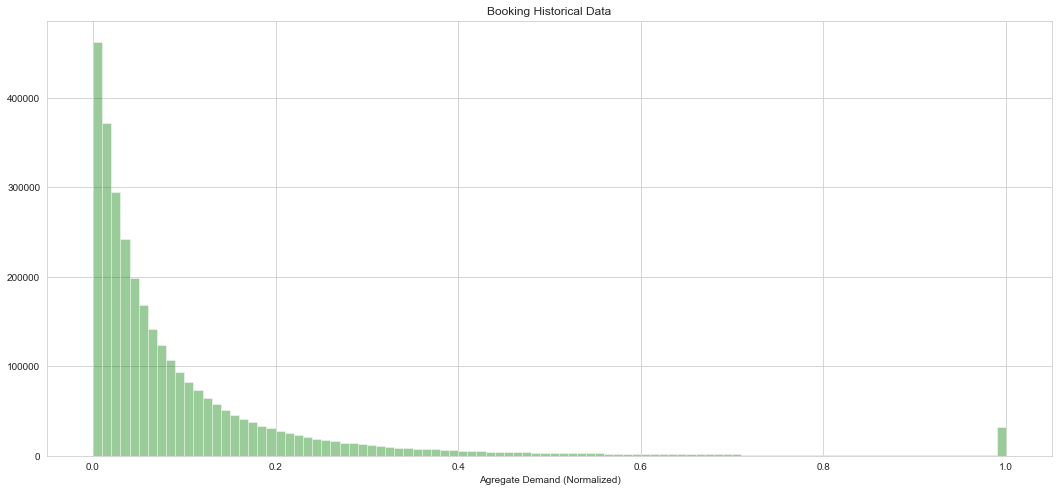

In [31]:
plt.figure(figsize = (18, 8))
sns.distplot(trainset['demand'],bins=100, kde=False,color='g')
plt.xlabel('Agregate Demand (Normalized)')
plt.title('Booking Historical Data')

2. Visualize the demand versus time chart to see the insight. The aggregate demand is high during time 0 to 10 and lowest around time 20. It rapidly increase after time 20.

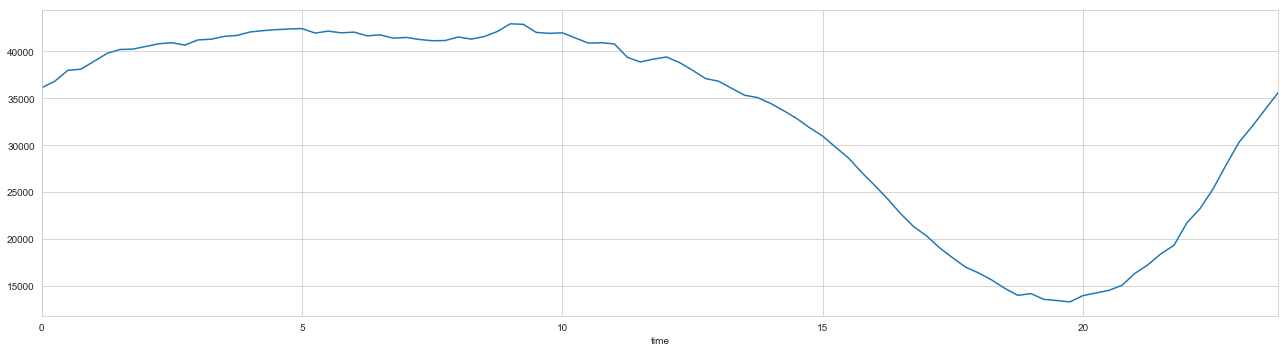

In [32]:
plt.figure(figsize=(18,5))
trainset.groupby('time').count()['demand'].plot()
plt.tight_layout()

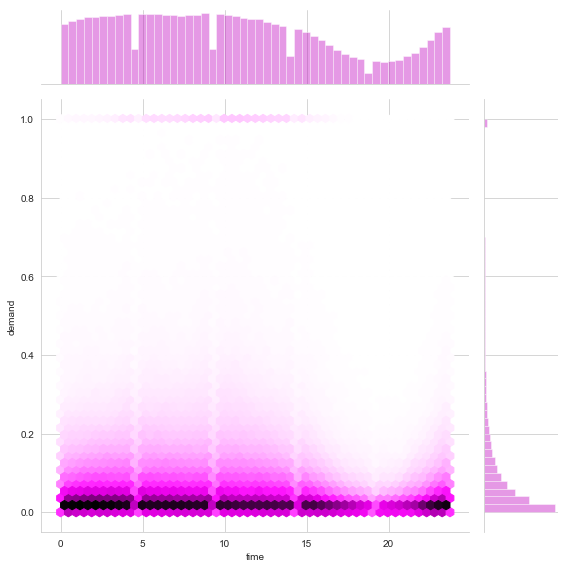

In [33]:
sns.jointplot(x='time',y='demand',data=trainset,kind='hex',height=8, color="m")


3. Visualize the demand versus day chart to see the insight. The average aggregate demand for first 30 days are slightly lower especially around day 17 and day 18. If we want to know what is happening on that day, further investigation required.

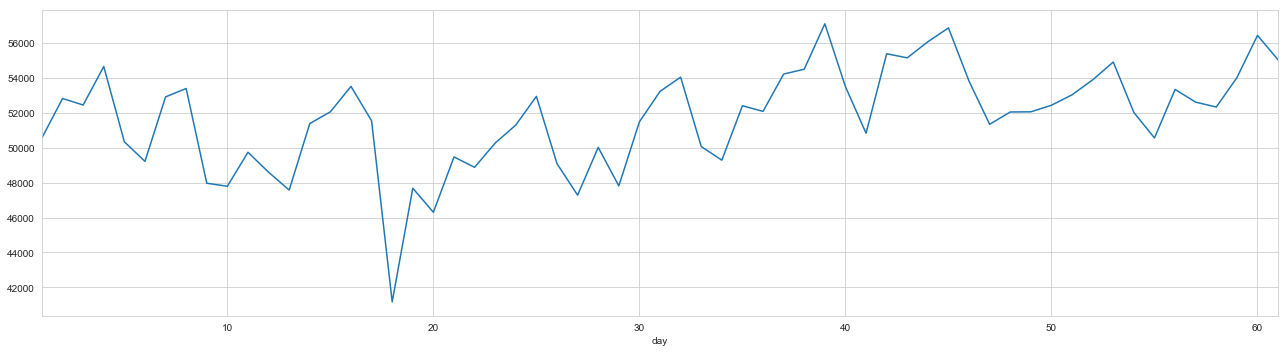

In [34]:
plt.figure(figsize=(18,5))
trainset.groupby('day').count()['demand'].plot()
plt.tight_layout()

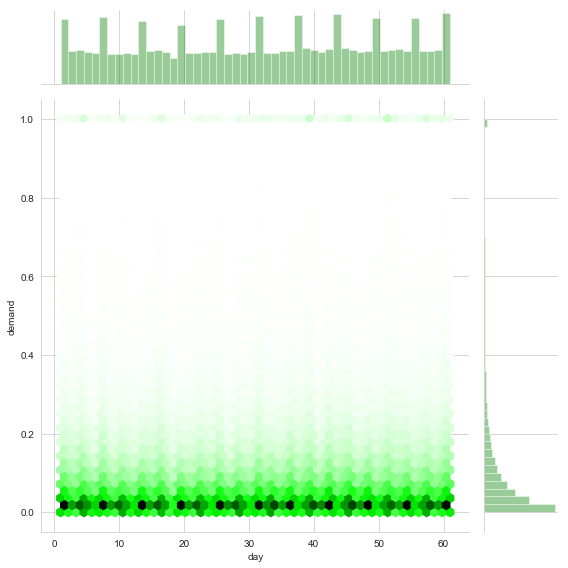

In [35]:
sns.jointplot(x='day',y='demand',data=trainset,kind='hex',height=8, color="g")


4. Visualize the demand versus latitude coordinate to find the insight. We will use heatmap for latitude and longtitude.

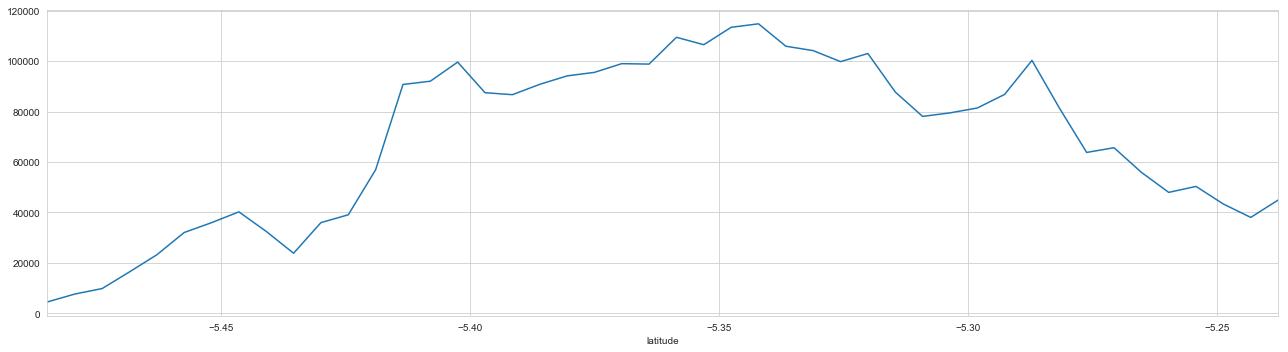

In [36]:
plt.figure(figsize=(18,5))
trainset.groupby('latitude').count()['demand'].plot()
plt.tight_layout()

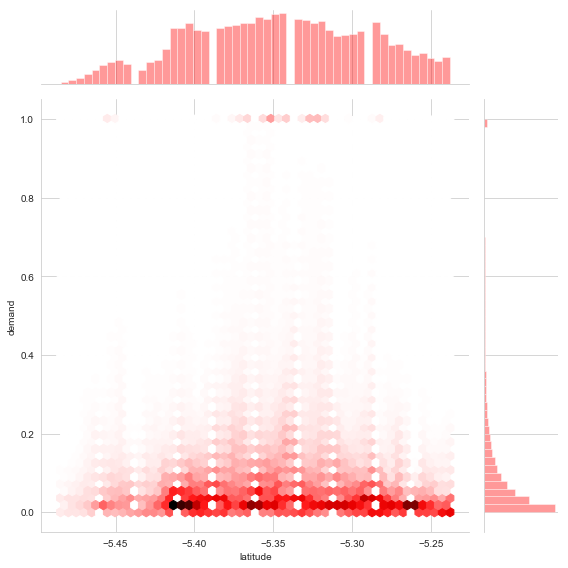

In [37]:
sns.jointplot(x='latitude',y='demand',data=trainset,kind='hex',height=8, color="r")


5. Visualize the demand versus longtitude coordinate to find the insight. We will use heatmap for latitude and longtitude.

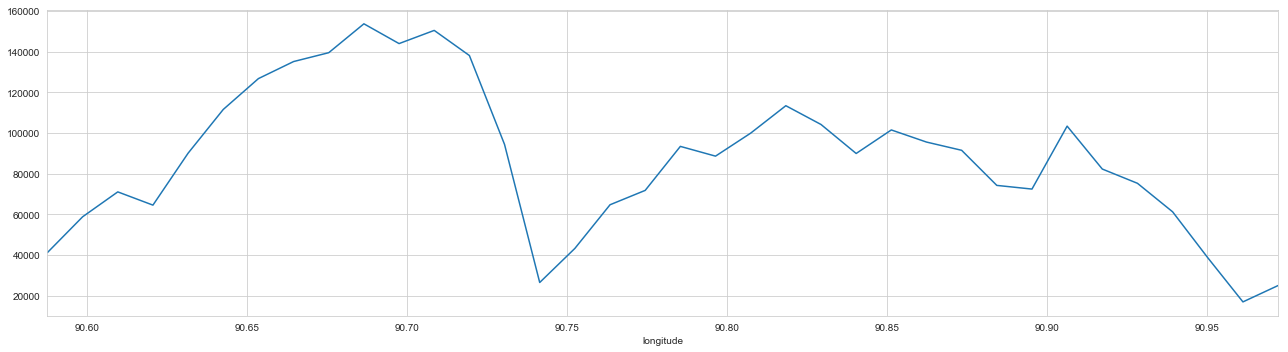

In [38]:
plt.figure(figsize=(18,5))
trainset.groupby('longitude').count()['demand'].plot()
plt.tight_layout()

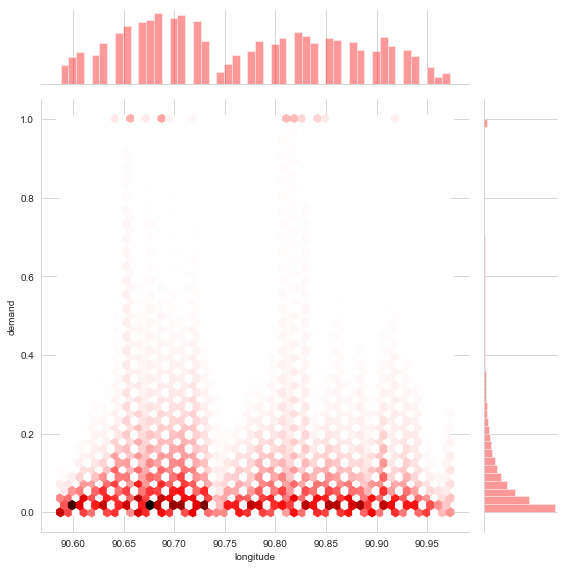

In [39]:
sns.jointplot(x='longitude',y='demand',data=trainset,kind='hex',height=8, color="r")


6. To see if the hour and minute have any relation to the demand. Hour mostly has the same shape as time. The minute plot shows the peaks of demand is during 0 minute and gradually decline as minute incline.

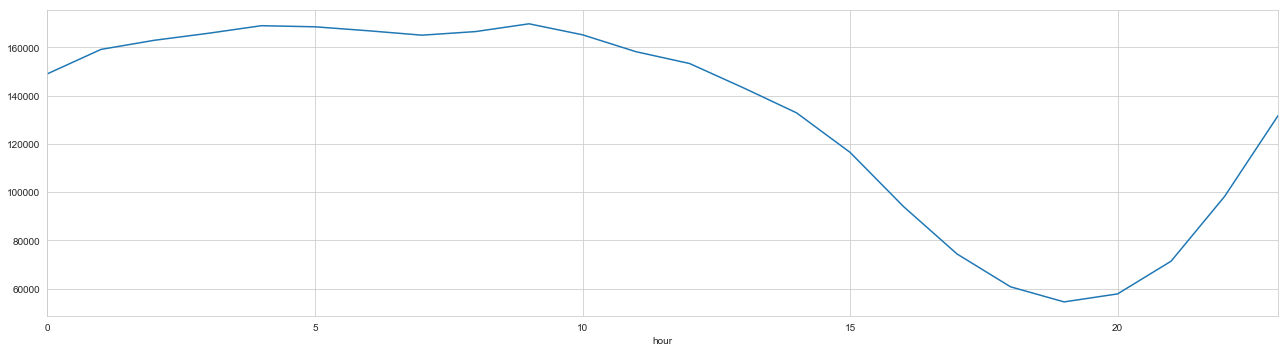

In [40]:
plt.figure(figsize=(18,5))
trainset.groupby('hour').count()['demand'].plot()
plt.tight_layout()

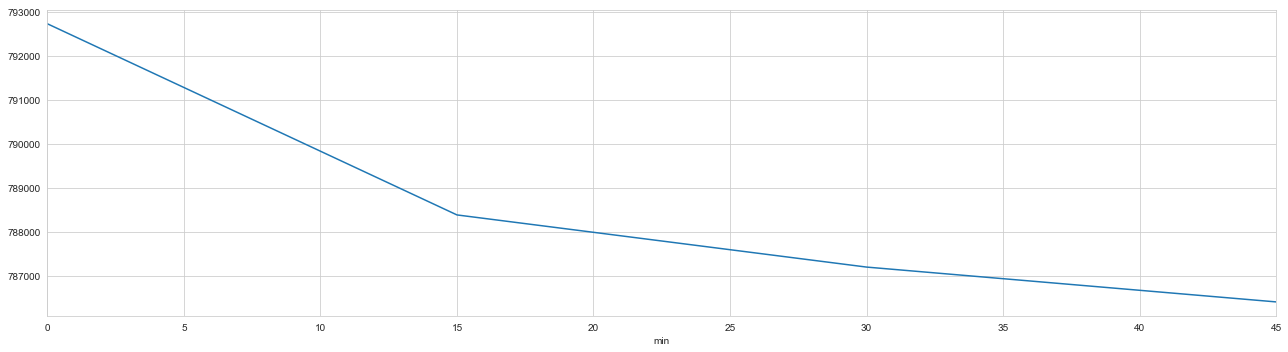

In [41]:
plt.figure(figsize=(18,5))
trainset.groupby('min').count()['demand'].plot()
plt.tight_layout()



7. In order to get heatmap, we will readjust the table and plot according to the table. From the heatmap, it seems that day 18 has outlier. We have to check other factor to verify such as what is happening on day 18.

In [42]:
dayTime = trainset.groupby(by=['day','time']).count()['demand'].unstack()
dayTime.head(10)

time,0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,...,21.5,21.75,22.0,22.25,22.5,22.75,23.0,23.25,23.5,23.75
day,,,,,,,,,,,,,,,,,,,,,
1,434.0,473.0,491.0,515.0,539.0,592.0,618.0,616.0,626.0,642.0,...,333.0,376.0,430.0,472.0,505.0,580.0,613.0,644.0,671.0,691.0
2,698.0,695.0,734.0,722.0,686.0,722.0,707.0,712.0,699.0,707.0,...,296.0,331.0,388.0,424.0,463.0,525.0,589.0,623.0,640.0,676.0
3,670.0,674.0,680.0,669.0,686.0,689.0,679.0,698.0,691.0,713.0,...,305.0,328.0,388.0,417.0,474.0,542.0,588.0,619.0,644.0,649.0
4,687.0,673.0,670.0,705.0,676.0,692.0,689.0,696.0,680.0,676.0,...,281.0,286.0,300.0,332.0,362.0,400.0,453.0,480.0,530.0,592.0
5,539.0,579.0,598.0,587.0,625.0,612.0,652.0,641.0,642.0,677.0,...,226.0,237.0,246.0,278.0,276.0,313.0,368.0,387.0,427.0,440.0
6,468.0,493.0,528.0,533.0,569.0,600.0,604.0,623.0,606.0,631.0,...,295.0,336.0,376.0,445.0,494.0,553.0,590.0,603.0,634.0,664.0
7,683.0,676.0,691.0,691.0,678.0,693.0,707.0,695.0,684.0,693.0,...,309.0,337.0,393.0,412.0,457.0,526.0,558.0,592.0,615.0,686.0
8,671.0,673.0,671.0,677.0,707.0,700.0,723.0,680.0,715.0,717.0,...,325.0,340.0,377.0,386.0,417.0,429.0,458.0,491.0,495.0,574.0
9,547.0,552.0,590.0,603.0,603.0,628.0,624.0,616.0,663.0,648.0,...,303.0,330.0,349.0,407.0,431.0,456.0,494.0,501.0,525.0,523.0


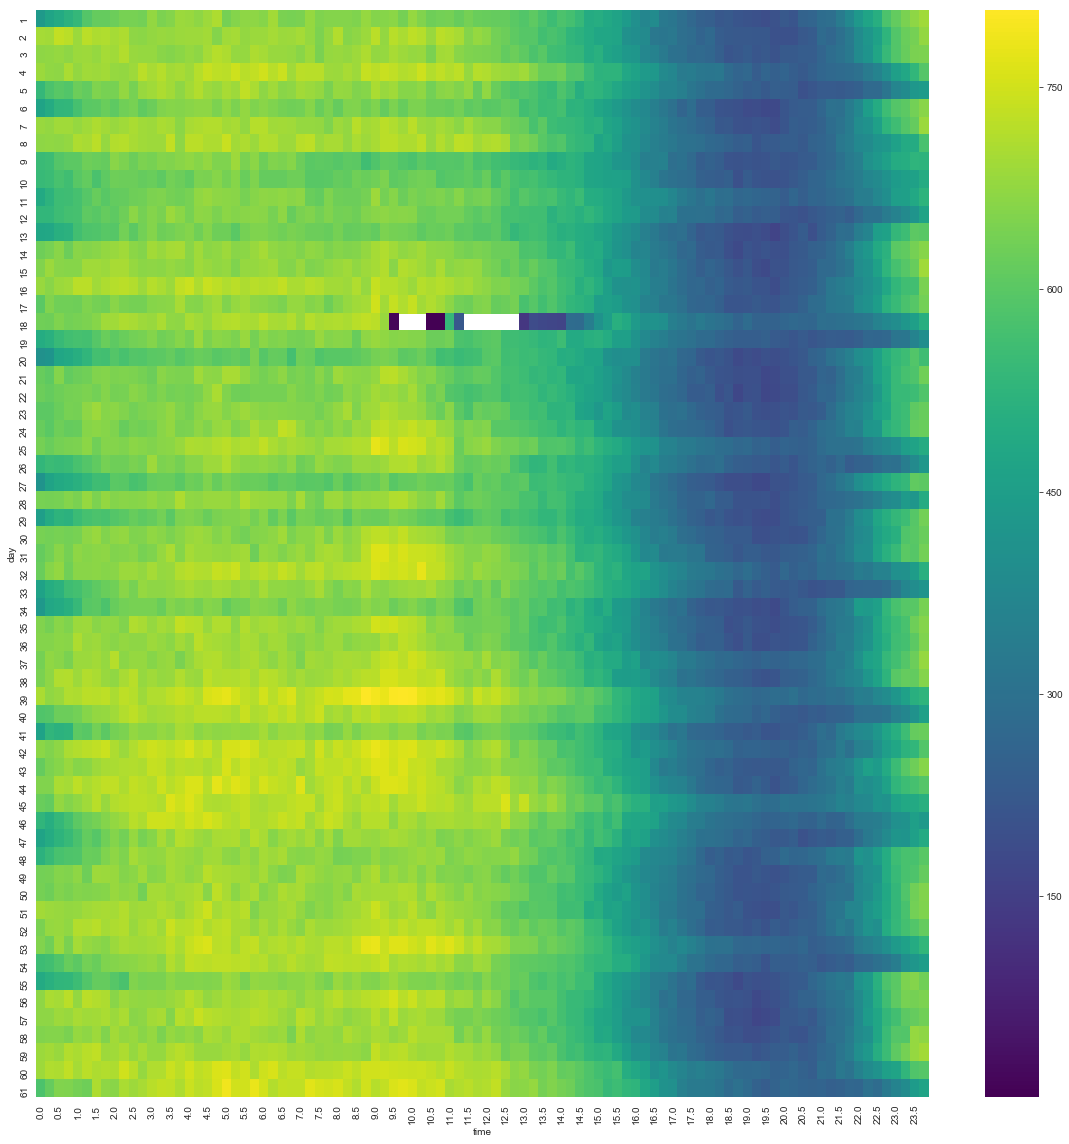

In [43]:
plt.figure(figsize=(20,20))
sns.heatmap(dayTime,cmap='viridis')

8. In order to get latitude and logtitude heatmap, we will readjust the table and plot accordingly. 

I have checked the location based on the coordinates using this [link](https://www.openstreetmap.org/), it located at the Indian Ocean near Indonesia's Sumatra which doesn't make sense.

In [44]:
latLon = trainset.groupby(by=['latitude','longitude']).count()['demand'].unstack()
latLon.head(10)

longitude,90.5877685546875,90.5987548828125,90.6097412109375,90.6207275390625,90.6317138671875,90.6427001953125,90.6536865234375,90.6646728515625,90.6756591796875,90.6866455078125,...,90.8734130859375,90.8843994140625,90.8953857421875,90.9063720703125,90.9173583984375,90.9283447265625,90.9393310546875,90.9503173828125,90.9613037109375,90.9722900390625
latitude,,,,,,,,,,,,,,,,,,,,,
-5.484924,NaN,NaN,NaN,NaN,NaN,NaN,430.0,873.0,424.0,881.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.479431,NaN,NaN,NaN,NaN,NaN,NaN,67.0,351.0,1367.0,1799.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.473938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1118.0,1823.0,2261.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.468445,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2229.0,1737.0,2207.0,...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.462952,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2438.0,2304.0,3527.0,...,656.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.457458,NaN,NaN,NaN,NaN,NaN,NaN,74.0,2497.0,1938.0,3297.0,...,1366.0,1310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.451965,NaN,NaN,NaN,NaN,NaN,NaN,643.0,2329.0,2626.0,3265.0,...,3271.0,286.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.446472,NaN,NaN,NaN,NaN,NaN,NaN,2120.0,1085.0,2791.0,2826.0,...,3026.0,2295.0,NaN,NaN,NaN,NaN,NaN,NaN,75.0,14.0
-5.440979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1106.0,2422.0,2437.0,...,2306.0,76.0,3.0,NaN,NaN,NaN,NaN,12.0,49.0,10.0


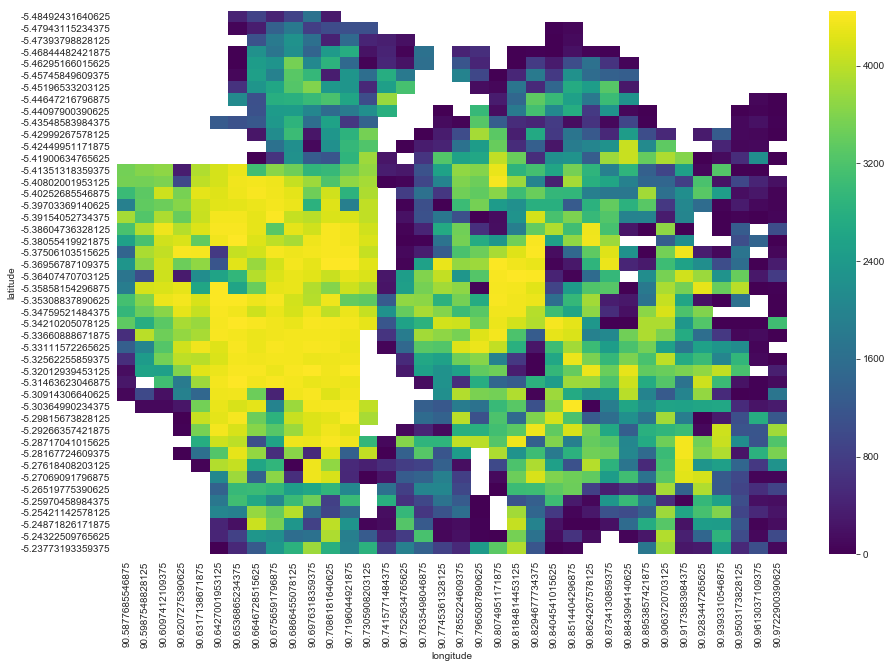

In [45]:
plt.figure(figsize=(15,10))
sns.heatmap(latLon,cmap='viridis')

___

## Setting up the Train Test Data

**Get data ready for the regression models.**


Check data info again

In [10]:
X_train = trainset[['time','day','latitude','longitude']].values
y_train = trainset['demand'].values

In [11]:
X_test = testset[['time','day','latitude','longitude']].values
y_test = testset['demand'].values

In [50]:
print(X_train.shape)
print(y_train.shape)

(3154740, 4)
(3154740,)


In [51]:
print(X_test.shape)
print(y_test.shape)

(1051581, 4)
(1051581,)


___

## eXtreme Gradient Boost - XGBoost model

### Train the XGBoost model

To start, import the XGBoost library and neccessary library. 

In [12]:
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

### Tune the model for the best parameter

In [13]:
# Start with standard parameter
xgb1 = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    n_jobs=-1,
                    nthread=96,
                    scale_pos_weight=1,
                    seed=27)
xgb1.fit(X_train, y_train)

scores_xgb1 = cross_val_score(xgb1, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('Scores for k=10 fold validation:',scores_xgb1)
print("Train MSE: %0.6f (+/- %0.6f)" % (scores_xgb1.mean(), scores_xgb.std() * 2))
print("Train RMSE: %0.6f" % math.sqrt(-(scores_xgb1.mean())))

In [ ]:
# Fix learning rate and no. estimators
param_test1 = {
    'max_depth':[7,9,10,15,20],
    'min_child_weight':[3,5,7,9,12]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 1.1,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=96,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test1, scoring='neg_mean_squared_error',iid=False, cv=5,n_jobs=-1)
gsearch1.fit(X_train,y_train)

gsearch1.best_params_
gsearch1.best_score_

In [ ]:
# Tune max depth and min child weight
param_test1b = {
    'max_depth':[40,60,100]
}
gsearch1b = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 5,
                    max_depth= 5,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test1b, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch1b.fit(X_train,y_train)

print('Best param:', gsearch1b.best_params_)
print('Best scores:', gsearch1b.best_score_)

In [ ]:
# Tune gamma
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0.1,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch3.fit(X_train,y_train)

print('Best param:', gsearch3.best_params_)
print('Best scores:', gsearch3.best_score_)

In [ ]:
# Tune subsample and colsample by tree
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.8,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch4.fit(X_train,y_train)

print('Best param:', gsearch4.best_params_)
print('Best scores:', gsearch4.best_score_)

In [ ]:
# Tune regularization parameter
param_test5 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch5.fit(X_train,y_train)

print('Best param:', gsearch5.best_params_)
print('Best scores:', gsearch5.best_score_)

In [ ]:
# Minor Tune, check the result previously
param_test6 = {
    'reg_alpha':[0.05, 0.1, 0.15, 0.2, 0.3]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    seed=27),
                       param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch6.fit(X_train,y_train)

print('Best param:', gsearch6.best_params_)
print('Best scores:', gsearch6.best_score_)

In [ ]:
# Tune estimators and learning rate
param_test7 = {
    'n_estimators':[50,100,200],
    'learning_rate':[0.01, 0.1, 0.2]
}
gsearch7 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    reg_alpha=0.2,                           
                    seed=27),
                       param_grid = param_test7, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch7.fit(X_train,y_train)

print('Best param:', gsearch7.best_params_)
print('Best scores:', gsearch7.best_score_)

In [ ]:
# Tune estimators and learning rate
param_test8 = {
    'n_estimators':[200,300,500],
    'learning_rate':[0.01, 0.1, 0.15]
}
gsearch8 = GridSearchCV(estimator = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=100,
                    #nthread=4,
                    scale_pos_weight=1,
                    reg_alpha=0.2,                           
                    seed=27),
                       param_grid = param_test8, scoring='neg_mean_squared_error',n_jobs=-1,iid=False, cv=5)
gsearch8.fit(X_train,y_train)

print('Best param:', gsearch8.best_params_)
print('Best scores:', gsearch8.best_score_)

### The best parameters from tuning are:
* gamma = 0
* min_child_weight = 5
* max_depth = 60
* subsample = 0.6
* colsample_bytree = 0.8
* learning_rate = 0.1
* n_estimators = 200
* reg_alpha = 0.2


In [14]:
xgb9 = XGBRegressor(booster='gbtree',
                    objective= 'reg:linear',
                    eval_metric='rmse',
                    gamma = 0,
                    min_child_weight= 5,
                    max_depth= 60,
                    subsample= 0.6,
                    colsample_bytree= 0.8,
                    tree_method= 'exact',
                    learning_rate=0.1,
                    n_estimators=200,
                    #nthread=4,
                    n_jobs=-1,
                    scale_pos_weight=1,
                    reg_alpha=0.2,                           
                    seed=27)

In [15]:
xgb9.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=60,
       min_child_weight=5, missing=None, n_estimators=200, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.2,
       reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.6, tree_method='exact')

### Cross Validation for new optimum parameter of XGBoost model
This is to test performance and overfitting using k-fold validation; here we take 10 folds, cv = 10.

In [16]:
scores_xgb = cross_val_score(xgb9, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [17]:
print('Scores for k=10 fold validation:',scores_xgb)
print("Train MSE: %0.6f (+/- %0.6f)" % (scores_xgb.mean(), scores_xgb.std() * 2))
print("Train RMSE: %0.6f" % math.sqrt(-(scores_xgb.mean())))

Scores for k=10 fold validation: [-0.00172954 -0.00171549 -0.00169699 -0.00171216 -0.00171941 -0.00171269
 -0.0017082  -0.00170338 -0.00172504 -0.00170892]
Train MSE: -0.001713 (+/- 0.000018)
Train RMSE: 0.041391


### Prediction for test dataset

In [18]:
xgb9_score = xgb9.score(X_test, y_test)
print("Prediction Score: %0.6f" % xgb9_score)

Prediction Score: 0.932505


In [19]:
# Predicting a rgb result
xgb9_pred = xgb9.predict(X_test)
from sklearn import metrics
print('Test MAE:', metrics.mean_absolute_error(y_test, xgb9_pred))
print('Test MSE:', metrics.mean_squared_error(y_test, xgb9_pred))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, xgb9_pred)))

Test MAE: 0.026864358501950906
Test MSE: 0.0017048931398081807
Test RMSE: 0.041290351655177034


### Residuals

Explore the residuals to make sure everything was okay with the data. 

**Plot a histogram of the residuals and make sure it looks normally distributed.**

(0, 30)

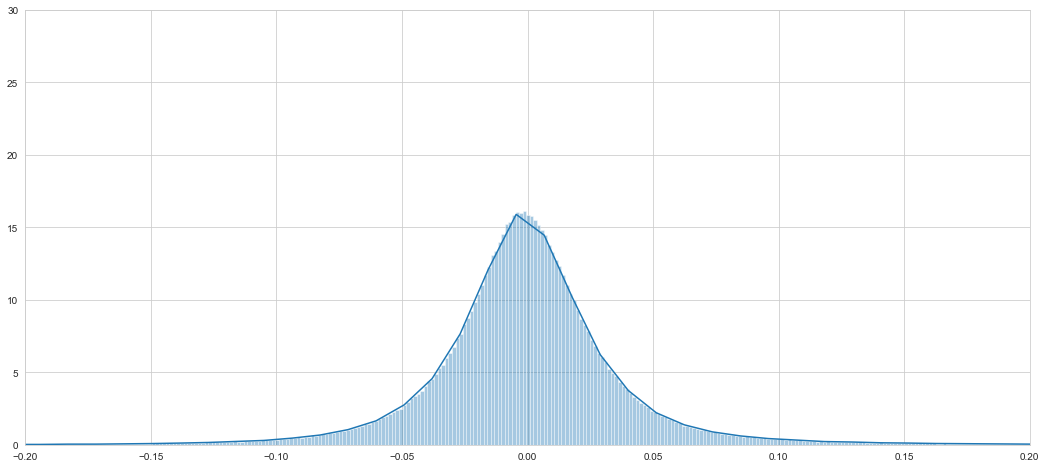

In [20]:
plt.figure(figsize=(18,8))
sns.distplot((y_test-xgb9_pred),bins=1000);
plt.xlim(-0.2,0.2)
plt.ylim(0,30)

### Visualize the features importance
There are features included: 
1. time, f0
2. day, f1
3. latitude, f2
4. longtude, f3

The result shows **time is the most important feature**.

In [21]:
print(xgb9.feature_importances_)

[0.35384938 0.26246685 0.20399931 0.17968445]


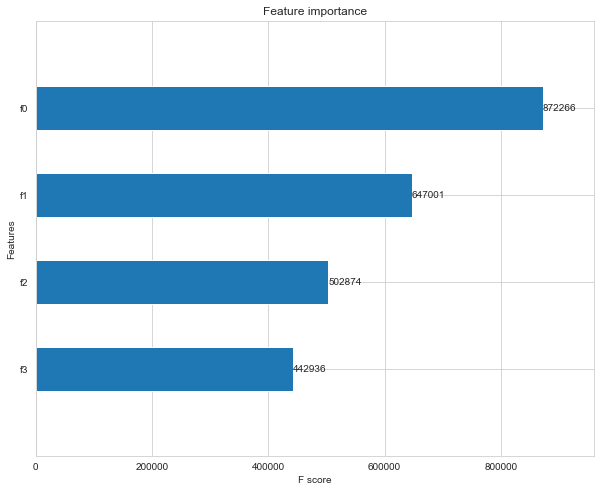

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
xgb.plot_importance(xgb9, height=0.5, ax=ax)
plt.show()

___

## Export the Prediction data

### Transform the time and Encode the coordinate

In [95]:
# define the data frame for the results
predict_demand = pd.DataFrame(xgb9_pred, columns=['predicted_demand'])

In [105]:
results = pd.concat([testset[['geohash6','day','timestamp']],predict_demand['predicted_demand']],axis=1)

In [118]:
results.to_csv('predicted_demand_submission.csv', index = False)

___